In [45]:
import glob
import os

import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
from einops import rearrange
import random
import sigpy as sp
from utils import prep_nufft
from radial_lsfp import MCNUFFT
import time
from typing import Union, List, Optional
import json
from utils import to_torch_complex
import math
import matplotlib.pyplot as plt

In [46]:
class SliceDataset(Dataset):
    """
    A Dataset that:
      - Looks for all .h5/.hdf5 files under `root_dir`.
      - Each file is assumed to contain a dataset at `dataset_key`, with shape (... Z),
        where Z is the number of slices/partitions.
      - Can either use a fixed set of slices or randomly sample N slices per volume
        at the start of each epoch.
      - Returns each slice as a torch.Tensor.
    """

    def __init__(
        self,
        root_dir,
        patient_ids,
        dataset_key="kspace",
        file_pattern="*.h5",
        slice_idx: Optional[Union[int, range]] = 41,
        num_random_slices: Optional[int] = None,  # New parameter for random sampling
        N_time=8,
        N_coils=16,
        spf_aug=False,
        spokes_per_frame=None,
        weight_accelerations=False, 
        initial_spokes_range=[2, 4, 8, 16, 24, 36]
    ):
        """
        Args:
            root_dir (str): Path to the folder containing all HDF5 k-space files.
            patient_ids (list): List of patient IDs to filter the files.
            dataset_key (str): The key/path inside each .h5 file to the k-space dataset.
            file_pattern (str): Glob pattern to match your HDF5 files.
            slice_idx (int, range, optional): A fixed slice index or range of indices to use.
                                              This is ignored if num_random_slices is set.
            num_random_slices (int, optional): If provided, the dataset will randomly sample
                                               this many slices from each volume at the beginning
                                               of each epoch.
        """
        super().__init__()

        self.root_dir = root_dir
        self.dataset_key = dataset_key
        self.slice_idx = slice_idx
        self.num_random_slices = num_random_slices
        self.N_time = N_time
        self.N_coils = N_coils
        self.spf_aug = spf_aug
        self.weight_acc = weight_accelerations

        # Find all matching HDF5 files under root_dir
        all_files = sorted(glob.glob(os.path.join(root_dir, file_pattern)))
        print("Number of files in root directory: ", len(all_files))

        if len(all_files) == 0:
            raise RuntimeError(
                f"No files found in {root_dir} matching pattern {file_pattern}"
            )

        # filter file list by patient ID substring
        filtered = []
        for fp in all_files:
            fname = os.path.basename(fp)
            if any(pid in fname for pid in patient_ids):
                filtered.append(fp)

        self.file_list = filtered

        if len(self.file_list) == 0:
            raise RuntimeError("No files matched the provided patient_ids filter.")

        # Logic for random slice sampling
        if self.num_random_slices is not None:
            print(f"Initializing in random slice sampling mode with N={self.num_random_slices} slices per volume.")
            self.volume_map = []
            for fp in self.file_list:
                with h5py.File(fp, "r") as f:
                    if self.dataset_key not in f:
                        raise KeyError(f"Dataset key '{self.dataset_key}' not found in file {fp}")
                    num_slices = f[self.dataset_key].shape[0]
                    self.volume_map.append((fp, num_slices))
            
            # Perform the initial random sampling for the first epoch
            self.resample_slices()
        
        # Original logic for fixed slices, executed only if not in random mode
        else:
            print(f"Initializing in fixed slice mode with slice_idx={self.slice_idx}.")
            self.slice_index_map = []
            for fp in self.file_list:
                with h5py.File(fp, "r") as f:
                    if self.dataset_key not in f:
                        raise KeyError(f"Dataset key '{self.dataset_key}' not found in file {fp}")
                    ds = f[self.dataset_key]
                    num_slices = ds.shape[0]

                slices_to_add = []
                if isinstance(self.slice_idx, int):
                    if self.slice_idx < num_slices:
                        slices_to_add = [self.slice_idx]
                    else:
                        print(f"Warning: slice_idx {self.slice_idx} is out of bounds for {fp} "
                              f"(size {num_slices}). Skipping this file for this slice.")
                elif isinstance(self.slice_idx, range):
                    slices_to_add = [s for s in self.slice_idx if s < num_slices]
                    if len(slices_to_add) < len(self.slice_idx):
                        print(f"Warning: Some requested slices were out of bounds for {fp}. "
                              f"Using only the valid slice indices from the provided range.")
                else:
                    raise TypeError(f"slice_idx must be an int, range, or None, but got {type(self.slice_idx)}")

                for z in slices_to_add:
                    self.slice_index_map.append((fp, z))

        print(f"Dataset initialized with {len(self.slice_index_map)} total slice examples.")

        self.spokes_per_frame = spokes_per_frame

        # NOTE: removed ultra-high accelerations until curriculum learning is implemented
        # self.spokes_range = [2, 4, 8, 16, 24, 36]
        # self.spokes_range = [8, 16, 24, 36]
        self.spokes_range = initial_spokes_range
        self.update_spokes_weights()
    
    def update_spokes_weights(self):

        if self.weight_acc:
            self.spf_weights = [1.0 / spf for spf in self.spokes_range]
        else:
            self.spf_weights = [1.0 for spf in self.spokes_range]


    def resample_slices(self):
        """
        Resamples N unique slices from each volume. This should be called at the
        beginning of each training epoch to ensure the model sees different data.
        """
        if self.num_random_slices is None:
            # If not in random sampling mode, do nothing.
            return

        self.slice_index_map = []
        for file_path, num_slices in self.volume_map:
            if num_slices >= self.num_random_slices:
                # Randomly sample N unique slices without replacement
                selected_slices = random.sample(range(num_slices), self.num_random_slices)
            else:
                # If the volume has fewer than N slices, take all of them.
                print(f"Warning: Volume {os.path.basename(file_path)} has only {num_slices} slices, "
                      f"which is less than the requested {self.num_random_slices}. Using all available slices.")
                selected_slices = list(range(num_slices))

            for z in selected_slices:
                self.slice_index_map.append((file_path, z))

    def load_dynamic_img(self, patient_id, slice):
        # This method remains unchanged
        H = W = 320
        data = np.empty((2, self.N_time, H, W), dtype=np.float32)
        
        for t in range(self.N_time):
            img_path = f'/ess/scratch/scratch1/rachelgordon/dce-{self.N_time}tf/{patient_id}/slice_{slice:03d}_frame_{t:03d}.nii'
            img = nib.load(img_path)
            img_data = img.get_fdata()

            if img_data.shape != (2, H, W):
                raise ValueError(f"{img_path} has shape {img_data.shape}; expected (2, {H}, {W})")

            data[:, t] = img_data.astype(np.float32)
            
        return torch.from_numpy(data)

    def load_csmaps(self, patient_id, slice):
        # This method remains unchanged
        ground_truth_dir = os.path.join(os.path.dirname(self.root_dir), 'cs_maps')
        csmap_path = os.path.join(ground_truth_dir, patient_id + '_cs_maps', f'cs_map_slice_{slice:03d}.npy')
        csmap = np.load(csmap_path)
        return csmap.squeeze()

    def __len__(self):
        return len(self.slice_index_map)

    def __getitem__(self, idx):
        # This method remains unchanged as it relies on self.slice_index_map
        file_path, current_slice_idx = self.slice_index_map[idx]
        current_slice_idx = int(current_slice_idx)
        patient_id = file_path.split('/')[-1].strip('.h5')

        # grasp_img = self.load_dynamic_img(patient_id, current_slice_idx)
        csmap = self.load_csmaps(patient_id, current_slice_idx)

        with h5py.File(file_path, "r") as f:
            ds = torch.tensor(f[self.dataset_key][:])
            kspace_slice = ds[current_slice_idx]

        if self.spf_aug or self.spokes_per_frame:
            total_spokes = kspace_slice.shape[0] * kspace_slice.shape[2]
            N_samples = kspace_slice.shape[-1]
            kspace = rearrange(kspace_slice, 't c sp sam -> t sp c sam')
            kspace_flat = kspace.contiguous().view(total_spokes, self.N_coils, N_samples)

            if self.spf_aug:
                print("setting random spokes per frame...")
                spokes_per_frame = random.choices(self.spokes_range, self.spf_weights, k=1)[0]
            else:
                spokes_per_frame = self.spokes_per_frame
                print(f"training with fixed spokes per frame ({spokes_per_frame})")

            N_time = total_spokes // spokes_per_frame
            kspace_binned = kspace_flat.view(N_time, spokes_per_frame, self.N_coils, N_samples)
            kspace_slice = rearrange(kspace_binned, 't sp c sam -> t c sp sam')
        else:
            N_time = self.N_time
            N_samples = kspace_slice.shape[-1]
            spokes_per_frame = kspace_slice.shape[-2]

        real_part = kspace_slice.real
        imag_part = kspace_slice.imag
        kspace_final = torch.stack([real_part, imag_part], dim=0).float()

        # kspace_final = torch.flip(kspace_final, dims=[-1])

        csmap_tensor = torch.from_numpy(csmap)
        # csmap_tensor = torch.rot90(csmap_tensor, k=2, dims=[-2, -1])
        csmap = csmap_tensor.numpy()

        return kspace_final, csmap, N_samples, spokes_per_frame, N_time, file_path
    


In [47]:
split_file = "/gpfs/data/karczmar-lab/workspaces/rachelgordon/breastMRI-recon/ddei/data/data_split.json"

with open(split_file, "r") as fp:
    splits = json.load(fp)


train_patient_ids = splits["train"]
    
train_dataset = SliceDataset(
        root_dir="/ess/scratch/scratch1/rachelgordon/dce-8tf/binned_kspace",
        patient_ids=train_patient_ids,
        dataset_key='ktspace',
        file_pattern="*.h5",
        slice_idx=41,
        num_random_slices=1,
        N_time=8,
        N_coils=16,
        spf_aug=False,
        spokes_per_frame=36,
        weight_accelerations=False,
    )


train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)


Number of files in root directory:  298
Initializing in random slice sampling mode with N=1 slices per volume.
Dataset initialized with 258 total slice examples.


training with fixed spokes per frame (36)
training with fixed spokes per frame (36)
training with fixed spokes per frame (36)
training with fixed spokes per frame (36)
torch.Size([1, 16, 320, 320])
torch.Size([16, 23040, 8])
torch.Size([2, 23040, 8])
torch.Size([320, 320, 8])
['/ess/scratch/scratch1/rachelgordon/dce-8tf/binned_kspace/fastMRI_breast_001_2.h5']
torch.Size([1, 16, 320, 320])
training with fixed spokes per frame (36)


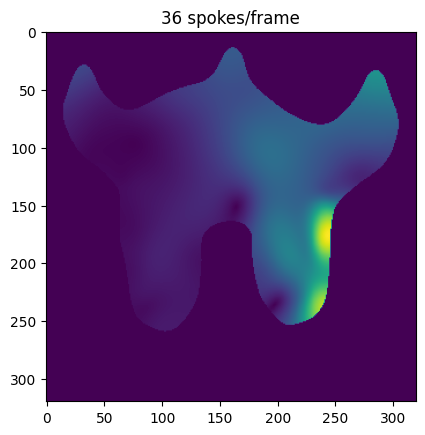

In [48]:
Ng = 24
device = torch.device("cuda")
N_full = 320 * math.pi / 2

for measured_kspace, csmap, N_samples, N_spokes, N_time, file_path in train_loader:

    # prepare inputs
    measured_kspace = to_torch_complex(measured_kspace).squeeze()
    measured_kspace = rearrange(measured_kspace, 't co sp sam -> co (sp sam) t')
    
    # if N_time > Ng:
    #     # prep physics operators
    #     ktraj, dcomp, nufft_ob, adjnufft_ob = prep_nufft(N_samples, N_spokes, Ng)
    #     ktraj = ktraj.to(device)
    #     dcomp = dcomp.to(device)
    #     nufft_ob = nufft_ob.to(device)
    #     adjnufft_ob = adjnufft_ob.to(device)

    #     physics = MCNUFFT(nufft_ob, adjnufft_ob, ktraj, dcomp)

    #     max_idx = N_time - Ng
    #     random_index = random.randint(0, max_idx - 1) 

    #     measured_kspace = measured_kspace[..., random_index:random_index + Ng]

    # else:
    # prep physics operators
    ktraj, dcomp, nufft_ob, adjnufft_ob = prep_nufft(N_samples, N_spokes, N_time)
    ktraj = ktraj.to(device)
    dcomp = dcomp.to(device)
    nufft_ob = nufft_ob.to(device)
    adjnufft_ob = adjnufft_ob.to(device)

    physics = MCNUFFT(nufft_ob, adjnufft_ob, ktraj, dcomp)


    csmap = csmap.to(device).to(measured_kspace.dtype)


    print(csmap.shape)
    print(measured_kspace.shape)
    print(physics.ktraj.shape)
    # 1. Get the initial ZF recon. This defines our target energy/scale.
    x_init = physics(inv=True, data=measured_kspace.to(device), smaps=csmap)

    print(x_init.shape)

    print(file_path)

    print(csmap.shape)

    csmap = csmap.squeeze()

    plt.imshow(np.abs(x_init[..., 0].cpu().numpy()), cmap='gray')
    plt.title(f"{N_spokes.item()} spokes/frame")

    plt.imshow(np.abs(csmap[0].cpu().numpy()))

    break

    


# Plot Validation Data


In [49]:

class SimulatedDataset(Dataset):
    """
    Dataset for loading the simulated data generated by your script.
    It loads the simulated k-space, coil sensitivity maps, and the
    ground truth dynamic image (DRO).
    """
    def __init__(self, root_dir, model_type, patient_ids, spokes_per_frame=36, num_frames=8):

        self.root_dir = root_dir
        self.patient_ids = patient_ids
        self.model_type = model_type
        self.spokes_per_frame = spokes_per_frame
        self.num_frames = num_frames

        self._update_sample_paths()


        self.TISSUE_NAMES = [
            'glandular', 'benign', 'malignant', 'muscle',
            'skin', 'liver', 'heart', 'vascular'
        ]

    def _update_sample_paths(self):
        self.dro_dir = os.path.join(self.root_dir, f'dro_{self.num_frames}frames')

        # Find all sample directories, e.g., 'sample_001_sub1', 'sample_002_sub2', etc.
        self.sample_paths = sorted(glob.glob(os.path.join(self.dro_dir, 'sample_*')))
        if not self.sample_paths:
            raise FileNotFoundError(f"No sample directories found in {self.dro_dir}. "
                                    "Please check the path to your simulated dataset.")
        
        # filter file list by patient ID substring
        filtered = []
        for fp in self.sample_paths:
            fname = os.path.basename(fp)
            # Check if any patient_id appears in the filename
            if any(pid in fname for pid in self.patient_ids):
                filtered.append(fp)

        self.sample_paths = filtered

        print(f"Found {len(self.sample_paths)} simulated samples in {self.dro_dir} for {self.num_frames} frames.")
        
    def __len__(self):
        return len(self.sample_paths)

    def __getitem__(self, idx):
        sample_dir = self.sample_paths[idx]

        # Load the data from .npy files
        csmaps = np.load(os.path.join(sample_dir, 'csmaps.npy'))
        dro = np.load(os.path.join(sample_dir, 'dro_ground_truth.npz'))
        # grasp_recon = np.load(os.path.join(sample_dir, f'grasp_spf{self.spokes_per_frame}_frames{self.num_frames}.npy'))

        grasp_path = os.path.join(sample_dir, f'grasp_spf{self.spokes_per_frame}_frames{self.num_frames}.npy')
        
        if os.path.exists(grasp_path):
            print("loading grasp image from ", grasp_path)
            grasp_recon = np.load(grasp_path)

            # GRASP Recon: (H, W, T) -> (2, T, H, W) [real/imag, time, h, w]
            grasp_recon_torch = torch.from_numpy(grasp_recon).permute(2, 0, 1) # T, H, W
            grasp_recon_torch = torch.stack([grasp_recon_torch.real, grasp_recon_torch.imag], dim=0)

            grasp_recon_torch = torch.flip(grasp_recon_torch, dims=[-3])
            grasp_recon_torch = torch.rot90(grasp_recon_torch, k=3, dims=[-3,-1])

        else:
            print("setting grasp img to zero")
            grasp_recon_torch = 0

        kspace_path = os.path.join(sample_dir, f'simulated_kspace_spf{self.spokes_per_frame}_frames{self.num_frames}.npy')

        if os.path.exists(kspace_path):
            kspace_complex = np.load(kspace_path, allow_pickle=True)
            kspace_torch = torch.from_numpy(kspace_complex)
        else:
            kspace_torch = kspace_path


        ground_truth_complex = dro['ground_truth_images']

        parMap = dro['parMap']
        aif = dro['aif']
        S0 = dro['S0']
        T10 = dro['T10']
        # mask = dro['mask']

        # ==========================================================
        # --- RECONSTRUCT THE MASK DICTIONARY ---
        # ==========================================================
        mask_dictionary_rebuilt = {}
        for tissue_name in self.TISSUE_NAMES:
            # Check if the key for this tissue (e.g., 'malignant') exists in the file
            if tissue_name in dro:
                # Load the boolean array and add it to the dictionary
                mask_dictionary_rebuilt[tissue_name] = dro[tissue_name]
        
        # 'mask' is now the dictionary of boolean arrays, just like your functions expect
        mask = mask_dictionary_rebuilt


        # --- Convert to PyTorch Tensors ---
        # Ground truth: (H, W, T) -> (2, T, H, W) [real/imag, time, h, w]
        ground_truth_torch = torch.from_numpy(ground_truth_complex).permute(2, 0, 1) # T, H, W
        ground_truth_torch = torch.stack([ground_truth_torch.real, ground_truth_torch.imag], dim=0)

        # CSMaps: (H, W, C) -> (1, C, H, W) [batch, coils, h, w]
        csmaps_torch = torch.from_numpy(csmaps).permute(2, 0, 1).unsqueeze(0)

        print("csmap: ", csmaps_torch.shape)
        print("gt: ", ground_truth_torch.shape)
        print("grasp: ", grasp_recon_torch.shape)


        csmaps_torch = torch.rot90(csmaps_torch, k=2, dims=[-2, -1])
        ground_truth_torch = torch.rot90(ground_truth_torch, k=2, dims=[-2, -1])
        grasp_recon_torch = torch.rot90(grasp_recon_torch, k=2, dims=[-3, -1])

        return kspace_torch, csmaps_torch, ground_truth_torch, grasp_recon_torch, mask, grasp_path #, parMap, aif, S0, T10, mask
    



In [50]:
# define physics object for evaluation
N_spokes_eval = 36
N_time_eval = 8

eval_ktraj, eval_dcomp, eval_nufft_ob, eval_adjnufft_ob = prep_nufft(N_samples, N_spokes_eval, N_time_eval)
eval_ktraj = eval_ktraj.to(device)
eval_dcomp = eval_dcomp.to(device)
eval_nufft_ob = eval_nufft_ob.to(device)
eval_adjnufft_ob = eval_adjnufft_ob.to(device)

eval_physics = MCNUFFT(eval_nufft_ob, eval_adjnufft_ob, eval_ktraj, eval_dcomp)

val_dro_patient_ids = splits["val_dro"]

val_dro_dataset = SimulatedDataset(
    root_dir="/ess/scratch/scratch1/rachelgordon/dro_dataset", 
    model_type="LSFPNet", 
    patient_ids=val_dro_patient_ids,
    spokes_per_frame=N_spokes_eval,
    num_frames=N_time_eval)


val_dro_loader = DataLoader(
    val_dro_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

Found 15 simulated samples in /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames for 8 frames.


loading grasp image from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_005_sub5/grasp_spf36_frames8.npy
loading grasp image from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_007_sub7/grasp_spf36_frames8.npy
csmap:  torch.Size([1, 16, 320, 320])
gt:  torch.Size([2, 8, 320, 320])
grasp:  torch.Size([2, 320, 8, 320])
csmap:  torch.Size([1, 16, 320, 320])
gt:  torch.Size([2, 8, 320, 320])
grasp:  torch.Size([2, 320, 8, 320])
loading grasp image from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_012_sub12/grasp_spf36_frames8.npy
loading grasp image from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_020_sub20/grasp_spf36_frames8.npy
csmap:  torch.Size([1, 16, 320, 320])
gt:  torch.Size([2, 8, 320, 320])
grasp:  torch.Size([2, 320, 8, 320])
csmap:  torch.Size([1, 16, 320, 320])
gt:  torch.Size([2, 8, 320, 320])
grasp:  torch.Size([2, 320, 8, 320])
loading grasp image from  /ess/scratch/scratch1/rachelgordon/d

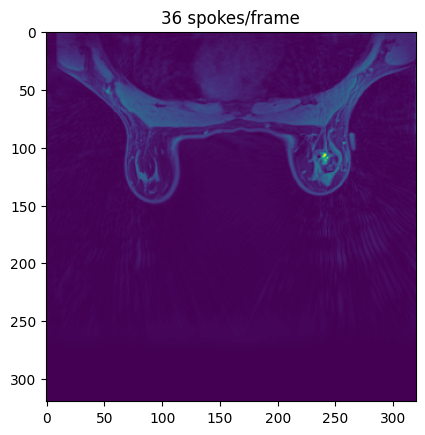

In [51]:
# Evaluate on validation data
for measured_kspace, csmap, ground_truth, grasp_img, mask, grasp_path in val_dro_loader:

    csmap = csmap.squeeze(0).to(device)   # Remove batch dim
    ground_truth = ground_truth.to(device) # Shape: (1, 2, T, H, W)

    # simulate k-space for validation if path does not exist
    if type(measured_kspace) is list:

        ground_truth_for_physics = rearrange(to_torch_complex(ground_truth), 'b t h w -> b h w t')
        kspace_path = measured_kspace[0]

        # SIMULATE KSPACE
        measured_kspace = eval_physics(False, ground_truth_for_physics, csmap)

        # save k-space 
        np.save(kspace_path, measured_kspace.cpu().numpy())


    measured_kspace = measured_kspace.squeeze(0).to(device) # Remove batch dim

    N_spokes = eval_ktraj.shape[1] / 640
    acceleration = torch.tensor([N_full / int(N_spokes)], dtype=torch.float, device=device)

    x_init = eval_physics(inv=True, data=measured_kspace.to(device), smaps=csmap)

    plt.imshow(np.abs(x_init[..., 0].cpu().numpy()), cmap='gray')
    plt.title(f"{int(N_spokes)} spokes/frame")


    csmap = csmap.squeeze()

    plt.imshow(np.abs(csmap[0].cpu().numpy()))

    print(ground_truth.shape)
    print(grasp_img.shape)

    ground_truth  = to_torch_complex(ground_truth).squeeze()

    plt.imshow(np.abs(ground_truth[0].cpu().numpy()))

    grasp_img  = to_torch_complex(grasp_img).squeeze()

    plt.imshow(np.abs(grasp_img[:, 0].cpu().numpy()))

    break

    
    

torch.Size([8, 320, 320])
torch.Size([320, 8, 320])


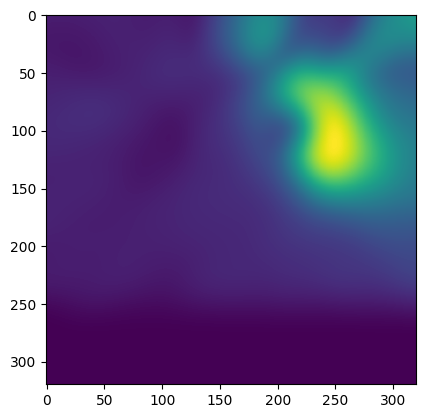

In [52]:
plt.imshow(np.abs(csmap[0].cpu().numpy()))

print(ground_truth.shape)
print(grasp_img.shape)



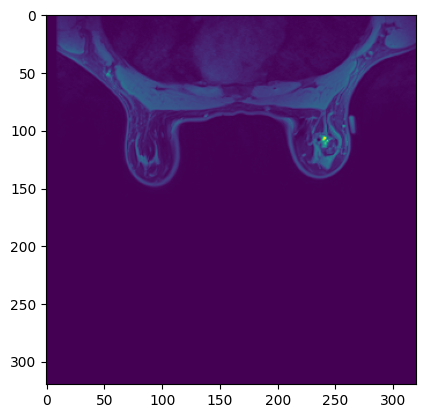

In [53]:
plt.imshow(np.abs(ground_truth[0].cpu().numpy()))



In [54]:
class SimulatedSPFDataset(Dataset):
    """
    Dataset for loading the simulated data generated by your script.
    It loads the simulated k-space, coil sensitivity maps, and the
    ground truth dynamic image (DRO).
    """
    def __init__(self, root_dir, model_type, patient_ids):
        self.model_type = model_type
        self.root_dir = root_dir
        self.patient_ids = patient_ids

        # set default parameters to be changed before each call
        self.spokes_per_frame = 36
        self.num_frames = 8

        # Initialize sample paths based on default parameters
        self._update_sample_paths()
        

        self.TISSUE_NAMES = [
            'glandular', 'benign', 'malignant', 'muscle',
            'skin', 'liver', 'heart', 'vascular'
        ]

    def _update_sample_paths(self):
        self.dro_dir = os.path.join(self.root_dir, f'dro_{self.num_frames}frames')

        # Find all sample directories, e.g., 'sample_001_sub1', 'sample_002_sub2', etc.
        self.sample_paths = sorted(glob.glob(os.path.join(self.dro_dir, 'sample_*')))
        if not self.sample_paths:
            raise FileNotFoundError(f"No sample directories found in {self.dro_dir}. "
                                    "Please check the path to your simulated dataset.")
        
        # filter file list by patient ID substring
        filtered = []
        for fp in self.sample_paths:
            fname = os.path.basename(fp)
            # Check if any patient_id appears in the filename
            if any(pid in fname for pid in self.patient_ids):
                filtered.append(fp)

        self.sample_paths = filtered

        print(f"Found {len(self.sample_paths)} simulated samples in {self.dro_dir} for {self.num_frames} frames.")

    def __len__(self):
        return len(self.sample_paths)

    def __getitem__(self, idx):
        sample_dir = self.sample_paths[idx]

        print(f"  Testing {self.spokes_per_frame} spokes/frame with {self.num_frames} frames.")

        print("loading data from ", sample_dir)

        # Load the data from .npy files
        # kspace_complex = np.load(os.path.join(sample_dir, 'simulated_kspace.npy'))
        csmaps = np.load(os.path.join(sample_dir, 'csmaps.npy'))
        dro = np.load(os.path.join(sample_dir, 'dro_ground_truth.npz'))

        grasp_path = os.path.join(sample_dir, f'grasp_spf{self.spokes_per_frame}_frames{self.num_frames}.npy')
        
        if os.path.exists(grasp_path):
            # print("loading grasp image from ", grasp_path)
            grasp_recon = np.load(grasp_path)

            # GRASP Recon: (H, W, T) -> (2, T, H, W) [real/imag, time, h, w]
            grasp_recon_torch = torch.from_numpy(grasp_recon).permute(2, 0, 1) # T, H, W
            grasp_recon_torch = torch.stack([grasp_recon_torch.real, grasp_recon_torch.imag], dim=0)


            grasp_recon_torch = torch.flip(grasp_recon_torch, dims=[-3])
            grasp_recon_torch = torch.rot90(grasp_recon_torch, k=3, dims=[-3,-1])

        else:
            # print("setting grasp img to zero")
            grasp_recon_torch = 0


        ground_truth_complex = dro['ground_truth_images']

        # SELECT TIME WINDOW
        # ground_truth_complex = ground_truth_complex[..., self.window]

        smap_torch = rearrange(torch.tensor(csmaps), 'h w c -> c h w').unsqueeze(0)
        simImg_torch = torch.tensor(ground_truth_complex).to(torch.cfloat)



        parMap = dro['parMap']
        aif = dro['aif']
        S0 = dro['S0']
        T10 = dro['T10']
        # mask = dro['mask']

        # ==========================================================
        # --- RECONSTRUCT THE MASK DICTIONARY ---
        # ==========================================================
        mask_dictionary_rebuilt = {}
        for tissue_name in self.TISSUE_NAMES:
            # Check if the key for this tissue (e.g., 'malignant') exists in the file
            if tissue_name in dro:
                # Load the boolean array and add it to the dictionary
                mask_dictionary_rebuilt[tissue_name] = dro[tissue_name]
        
        # 'mask' is now the dictionary of boolean arrays, just like your functions expect
        mask = mask_dictionary_rebuilt


        # --- Convert to PyTorch Tensors ---
        # Ground truth: (H, W, T) -> (2, T, H, W) [real/imag, time, h, w]
        ground_truth_torch = torch.from_numpy(ground_truth_complex).permute(2, 0, 1) # T, H, W
        ground_truth_torch = torch.stack([ground_truth_torch.real, ground_truth_torch.imag], dim=0)

        print(smap_torch.shape)
        print(simImg_torch.shape)
        print(grasp_recon_torch.shape)

        smap_torch = torch.rot90(smap_torch, k=2, dims=[-2, -1])
        simImg_torch = torch.rot90(simImg_torch, k=2, dims=[0, 1])
        grasp_recon_torch = torch.rot90(grasp_recon_torch, k=2, dims=[-3, -1])


        return smap_torch, simImg_torch, grasp_recon_torch, mask, grasp_path #, parMap, aif, S0, T10, mask



In [55]:
spokes = 36
num_frames = 8
eval_spf_dataset = SimulatedSPFDataset(
    root_dir="/ess/scratch/scratch1/rachelgordon/dro_dataset", 
    model_type="LSFPNet", 
    patient_ids=val_dro_patient_ids,
    )


eval_spf_loader = DataLoader(
    eval_spf_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
)

Found 15 simulated samples in /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames for 8 frames.


  Testing 36 spokes/frame with 8 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_005_sub5
  Testing 36 spokes/frame with 8 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_007_sub7
torch.Size([1, 16, 320, 320])
torch.Size([320, 320, 8])
torch.Size([2, 320, 8, 320])
torch.Size([1, 16, 320, 320])
torch.Size([320, 320, 8])
torch.Size([2, 320, 8, 320])
  Testing 36 spokes/frame with 8 frames.
  Testing 36 spokes/frame with 8 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_020_sub20
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames/sample_012_sub12
torch.Size([1, 16, 320, 320])
torch.Size([320, 320, 8])
torch.Size([2, 320, 8, 320])
torch.Size([1, 16, 320, 320])
torch.Size([320, 320, 8])
torch.Size([2, 320, 8, 320])
  Testing 36 spokes/frame with 8 frames.
loading data from  /ess/scratch/scratch1/rachelgordon/dro_dataset/dro_8frames

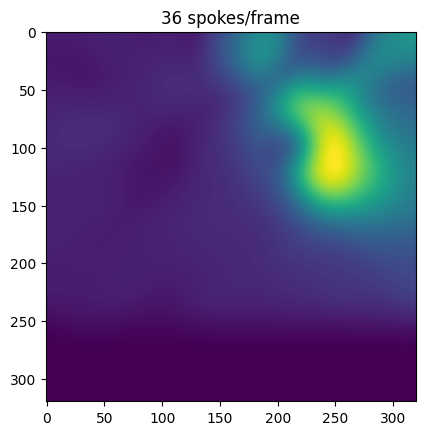

In [58]:
for csmap, ground_truth, grasp_img, mask, grasp_path in eval_spf_loader:


            csmap = csmap.squeeze(0).to(device)   # Remove batch dim
            ground_truth = ground_truth.to(device) # Shape: (1, 2, T, H, W)


            # SIMULATE KSPACE
            ktraj, dcomp, nufft_ob, adjnufft_ob = prep_nufft(N_samples, spokes, num_frames)
            physics = MCNUFFT(nufft_ob.to(device), adjnufft_ob.to(device), ktraj.to(device), dcomp.to(device))


            sim_kspace = physics(False, ground_truth, csmap)

            kspace = sim_kspace.squeeze(0).to(device) # Remove batch dim


            x_init = eval_physics(inv=True, data=kspace.to(device), smaps=csmap)

            plt.imshow(np.abs(x_init[..., 0].cpu().numpy()), cmap='gray')
            plt.title(f"{int(N_spokes)} spokes/frame")


            csmap = csmap.squeeze()

            plt.imshow(np.abs(csmap[0].cpu().numpy()))

            print(ground_truth.shape)
            print(grasp_img.shape)


            break

    
    



Text(0.5, 1.0, '36 spokes/frame')

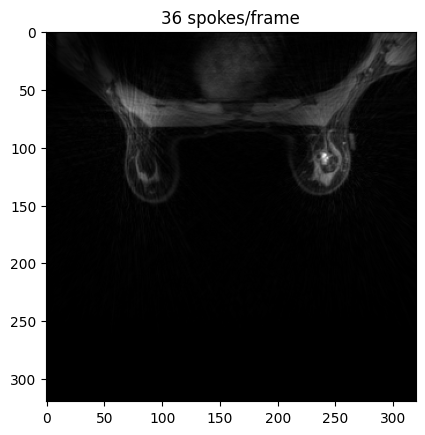

In [59]:
plt.imshow(np.abs(x_init[..., 0].cpu().numpy()), cmap='gray')
plt.title(f"{int(N_spokes)} spokes/frame")

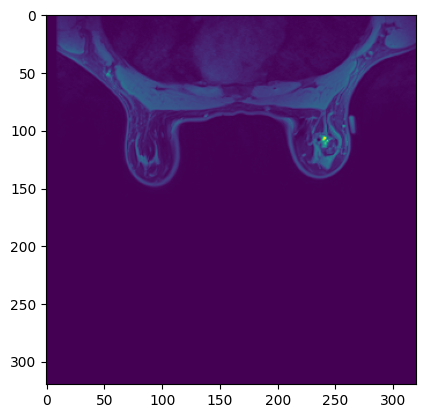

In [60]:
# ground_truth  = to_torch_complex(ground_truth).squeeze()

plt.imshow(np.abs(ground_truth[..., 0].squeeze().cpu().numpy()))



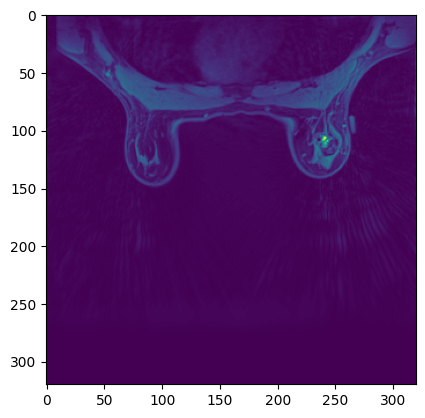

In [61]:
grasp_img  = to_torch_complex(grasp_img).squeeze()

plt.imshow(np.abs(grasp_img[:, 0].cpu().numpy()))